In [1]:
import pandas as pd
import mysql.connector
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
csv_files=[
    ('customers.csv','customers'),
    ('orders.csv','orders'),
    ('products.csv','products'),
    ('sellers.csv','sellers'),
    ('geolocation.csv','geolocation'),
    ('payments.csv','payments'),
    ('order_items.csv','order_items')
    
]

In [3]:
conn=mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='e_commerce',
    auth_plugin='mysql_native_password'

)

In [4]:
a=pd.read_sql_query("""SELECT DISTINCT customer_city FROM customers""",conn)
a

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


In [4]:
cur=conn.cursor()

In [44]:
folder_path="C:/Users/prati/Downloads/Sql e-Commerce Project"

In [38]:
def get_sql_type(pandas_dtype):
    # Implement your logic to map Pandas data types to SQL data types
    # Example mapping:
    if pandas_dtype == 'object':
        return 'VARCHAR(255)'
    elif pandas_dtype == 'int64':
        return 'INT'
    elif pandas_dtype == 'float64':
        return 'FLOAT'
    # Add more mappings as needed
    else:
        raise ValueError(f"Unsupported Pandas dtype: {pandas_dtype}")


In [45]:
try:
    cursor = conn.cursor()

    #  csv_files is a list of tuples like [(filename1.csv, table_name1), (filename2.csv, table_name2), ...]
    for csv_file, table_name in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Replace NaN with None to handle SQL NULL
        df = df.where(pd.notnull(df), None)
        
        # Debugging: Check for NaN values
        print(f"Processing {csv_file}")
        print(f"NaN values before replacement:\n{df.isnull().sum()}\n")
        
        # Clean column names
        df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

        # Generate the CREATE TABLE statement with appropriate data types
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        cursor.execute(create_table_query)

        # Insert DataFrame data into the MySQL table
        for _, row in df.iterrows():
            # Convert row to tuple and handle NaN/None explicitly
            values = tuple(None if pd.isna(x) else x for x in row)
            sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
            cursor.execute(sql, values)

        # Commit the transaction for the current CSV file
        conn.commit()

    # Close cursor and commit any remaining changes
    cursor.close()

finally:
    # Close the connection
    conn.close()

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing payments.csv
NaN values before replacement:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64



1. List all unique cities where customers are located.

In [72]:
query=("""SELECT DISTINCT customer_city FROM customers""")
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['Country'])
df.head()


,Country
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. Count the number of orders placed in 2017.

In [19]:
query=("""SELECT COUNT(order_id) FROM orders
          where year(order_purchase_timestamp)=2017 """)
cur.execute(query)
data= cur.fetchall()
"total orders placed in 2017 are",data[0][0]


('total orders placed in 2017 are', 45101)

3. Find the total sales per category.

In [36]:
query=("""select products.product_category category,round(sum(payments.payment_value),2) sales
            from products join order_items
            on products.product_id=order_items.product_id
            join payments
            on payments.order_id=order_items.order_id
            group by category """)
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=["Category","Sales"])
df.head()

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


4. Calculate the percentage of orders that were paid in installments.

In [44]:
query=("""select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 
        from payments""")
cur.execute(query)
data= cur.fetchall()
"The percentage of orders that were paid in installments is", data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

5. Count the number of customers from each state.

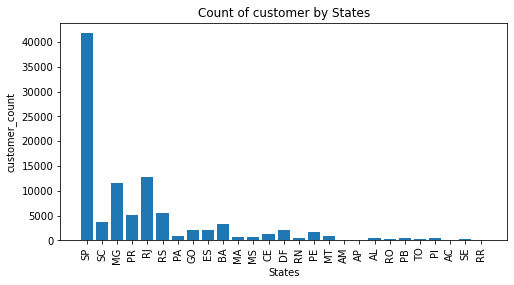

In [78]:
query=("""select customer_state,count(customer_id) as customer_count
            from customers group by customer_state""")
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['State','Customer_count'])
df.sort_values(by='Customer_count',ascending=False)


plt.figure(figsize=(8,4))
plt.bar(df['State'],df['Customer_count'])
plt.xticks(rotation=90)
plt.xlabel('States')
plt.ylabel('customer_count')
plt.title("Count of customer by States")
plt.show()



6. Calculate the number of orders per month in 2018.

In [110]:
query=("""select monthname(order_purchase_timestamp) months, count(order_id)
            from orders where year(order_purchase_timestamp)=2018
            group by months order by month(order_purchase_timestamp)  """)
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['months','no_of_orders'])
df


,months,no_of_orders
0,January,7269
1,February,6728
2,March,7211
3,April,6939
4,May,6873
5,June,6167
6,July,6292
7,August,6512
8,September,16
9,October,4


7. Find the average number of products per order, grouped by customer city.

In [87]:
query="""with count_per_order as
            (select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
                from orders join order_items
                on orders.order_id=order_items.order_id
                group by orders.order_id,orders.customer_id )
            
            select customers.customer_city,round(avg(count_per_order.oc),2) average_order
            from customers join count_per_order
            on customers.customer_id=count_per_order.customer_id
            group by customers.customer_city"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['city','Avg_products_per_order'])
df

,city,Avg_products_per_order
0,sao paulo,1.16
1,canoas,1.11
2,bage,1.05
3,brasilia,1.13
4,rio de janeiro,1.15
...,...,...
4105,morro agudo de goias,1.00
4106,morro vermelho,1.00
4107,guairaca,2.00
4108,vila bela da santissima trindade,1.00


8. Calculate the percentage of total revenue contributed by each product category.

In [95]:
query="""select products.product_category category,round((sum(payments.payment_value)/(select sum(payment_value)
            from payments))*100,2) sales_percentage
            from products join order_items
            on products.product_id=order_items.product_id
            join payments
            on payments.order_id=order_items.order_id
            group by category  order by sales_percentage desc """
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['Categogy','Percentage_distribution'])
df.head()

,Categogy,Percentage_distribution
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


9. Identify the correlation between product price and the number of times a product has been purchased.

In [103]:
query="""select products.product_category,count(order_items.product_id),
        round(avg(order_items.price),2) from products join order_items
        on products.product_id=order_items.product_id
        group by products.product_category"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Order_count','Price'])
df.head()
a=np.corrcoef(df['Order_count'],df['Price'])
print('The correlation between price and number of times\naproduct has been purchased is ',round(a[0][1],2))

The correlation between price and number of times
aproduct has been purchased is  -0.11


10. Calculate the total revenue generated by each seller, and rank them by revenue.

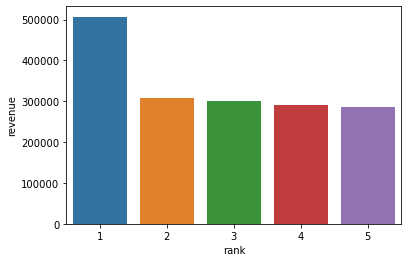

In [37]:
query="""select *,dense_rank() over(order by revenue desc) as rn from
        (select order_items.seller_id,sum(payments.payment_value)
        revenue from order_items join payments
        on  order_items.order_id=payments.order_id
        group by order_items.seller_id) as a"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['seller_id','revenue','rank'])
df_head=df.head()
sns.barplot(x='rank',y='revenue',data=df_head)
plt.show()

11. Calculate the moving average of order values for each customer over their order history.

In [34]:
query="""select customer_id,order_purchase_timestamp,payment,
            avg(payment) over(partition by customer_id
            order by order_purchase_timestamp rows between 2 preceding
            and current row) as mov_avg
            from
            (select orders.customer_id,orders.order_purchase_timestamp,
            payments.payment_value as payment
            from payments join orders
            on payments.order_id=orders.order_id) as a"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['customer_id','date/time','Order_value','Running_Avg'])
df.head()

,customer_id,date/time,Order_value,Running_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


12. Calculate the cumulative sales per month for each year.

In [13]:
query="""select years,months,payment,sum(payment)
            over(order by years,months) cumulative_sales from
            (select year(orders.order_purchase_timestamp) as years,
            monthname(orders.order_purchase_timestamp) as months,
            round(sum(payments.payment_value),2) as payment
            from orders join payments
            on orders.order_id=payments.order_id
            group by years,months order by years,months) as a"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['years','month','payments','cume_payment'])
df.head()


,years,month,payments,cume_payment
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69


13. Calculate the year-over-year growth rate of total sales.

In [41]:
query="""         WITH cte AS (
    SELECT
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM
        orders
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY
        years
),
cte2 AS (
    SELECT
        c1.years,
        c1.payment,
        c2.payment AS pre_year_payment
    FROM
        cte c1
    JOIN cte c2 ON c1.years = c2.years + 1
)
SELECT
    cte2.*,
    ((cte.payment - pre_year_payment) / pre_year_payment) * 100 AS YOYGrowth
FROM
    cte2
JOIN cte ON cte2.years = cte.years
ORDER BY
    cte2.years;
            
            """
cur.execute(query)
data= cur.fetchall()
data
df=pd.DataFrame(data,columns=['Years','Payments','Pre_Year_payment','YoY% Growth'])
df

,Years,Payments,Pre_Year_payment,YoY% Growth
0,2017,7249746.73,59362.34,12112.703761
1,2018,8699763.05,7249746.73,20.000924


14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [139]:
query="""with a as (select customers.customer_id,min(orders.order_purchase_timestamp)
            first_order from customers join orders
            on customers.customer_id=orders.customer_id
            group by customers.customer_id),
            
            b as (select a.customer_id,count(distinct orders.order_purchase_timestamp)
            from a join orders
            on orders.customer_id=a.customer_id
            and orders.order_purchase_timestamp>first_order
            and orders.order_purchase_timestamp<
            date_add(first_order,interval 6 month)
            group by a.customer_id)
            select 100*(count(distinct a.customer_id)/count(distinct b.customer_id) )
            from a left join b
            on a.customer_id=b.customer_id"""
cur.execute(query)

data= cur.fetchall()
data

[(None,)]

15. Identify the top 3 customers who spent the most money in each year.

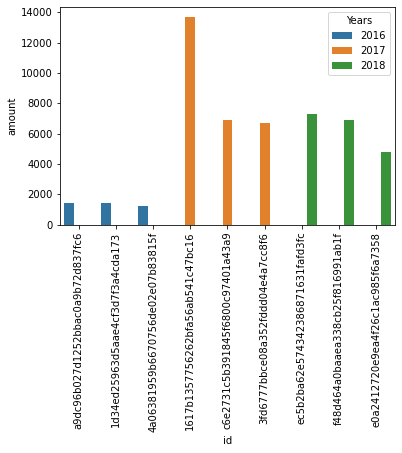

In [21]:
query="""select years,customer_id,payment,d_rank from
            (select year(orders.order_purchase_timestamp) years,orders.customer_id,sum(payments.payment_value) payment,
            dense_rank() over(partition by year(orders.order_purchase_timestamp)
            order by sum(payments.payment_value) desc) d_rank
            from orders join payments
            on payments.order_id=orders.order_id
            group by year(orders.order_purchase_timestamp),
            orders.customer_id) as a 
            where d_rank<=3"""
cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=['Years','id','amount','rank'])
sns.barplot(x='id',y='amount',data=df,hue='Years')
plt.xticks(rotation=90)
plt.show()